<a href="https://colab.research.google.com/github/Maxarreaga/APS360/blob/main/init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the initilization for our APS360 Project

In [1]:
# Imports
from functools import partial
import numpy as np
import pandas as pd 
import random 
import math 
import cv2 
import os 
import shutil
import pathlib
from google.colab import files
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
!mkdir -p root/.kaggle/

In [3]:
!pip install ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

     |████████████████████████████████| 54.7 MB 1.3 MB/s 
     |████████████████████████████████| 119 kB 53.8 MB/s 


In [5]:
def get_kaggle_data():
  print('Upload Kaggle api token :')
  files.upload()
  !pip install -q kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json 

  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data

get_kaggle_data()

Upload Kaggle api token :


Saving kaggle.json to kaggle (1).json
kaggle.json
 99% 603M/612M [00:05<00:00, 119MB/s]
100% 612M/612M [00:05<00:00, 122MB/s]


In [6]:
tran = transforms.Compose([transforms.Resize((32,32)),
                           transforms.Grayscale(),
                           transforms.RandomAffine(degrees=20,translate=(0,0.1),scale=(1,1.2)),
                           #transforms.Normalize((0.5,),(0.5,)),
                           transforms.ToTensor()
                           ])

In [22]:
image_datasets = torchvision.datasets.ImageFolder('/content/Data/Train', transform=tran)

num_images = len(image_datasets)
train_split_val = round(num_images*0.75)

test_set = image_datasets
train_set, val_set = torch.utils.data.random_split(image_datasets,[train_split_val,num_images-train_split_val])
print('Train Set: ', len(train_set))
print('Validation Set: ', len(val_set))
print('Test Set: ', len(test_set))


Train Set:  29407
Validation Set:  9802
Test Set:  39209


In [8]:
# Pytorch assigns its own numbers as labels so they dont match up with the folder number names in the dataset
# This part is needed to interpret the prediction
dict((int(i),int(l)) for l,i in image_datasets.class_to_idx.items())

{0: 0,
 1: 1,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 2,
 13: 20,
 14: 21,
 15: 22,
 16: 23,
 17: 24,
 18: 25,
 19: 26,
 20: 27,
 21: 28,
 22: 29,
 23: 3,
 24: 30,
 25: 31,
 26: 32,
 27: 33,
 28: 34,
 29: 35,
 30: 36,
 31: 37,
 32: 38,
 33: 39,
 34: 4,
 35: 40,
 36: 41,
 37: 42,
 38: 5,
 39: 6,
 40: 7,
 41: 8,
 42: 9}

In [23]:
# Creating DataLoader 
batch_size = 100
num_workers = 1
print("trainSet Columns = {}", train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


trainSet Columns = {} <torch.utils.data.dataset.Subset object at 0x7f7e24cc1d10>


In [10]:
def get_accuracy(model, data, device):
    """ Compute the accuracy of the `model` across a dataset `data`
    """

    # From tutorial
    correct,total = 0, 0
    for img, labels in data:
      img, labels = img.to(device), labels.to(device)
      result = model(img)
      pred = result.max(1,keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += labels.shape[0]
    accuracy = correct/total
    return accuracy

In [11]:
# 
class GTSRBClassifier(nn.Module):
  def __init__(self, conv1Channels = 32, conv2Channels = 64, features = 64):
    self.name = "GTSRBClassifier"
    super(GTSRBClassifier,self).__init__()
    self.conv1 = nn.Conv2d(1,conv1Channels,3) #format is in (1 if greyscale 3 if rgb),out channel third number, kernel
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(conv1Channels,conv2Channels,3)
    self.conv3 = nn.Conv2d(conv2Channels,128,3)
    self.fc1 = nn.Linear(2*2*128,features)
    self.fc2 = nn.Linear(features,43)

  def forward(self,image):
    image = self.pool(F.relu(self.conv1(image)))
    image = self.pool(F.relu(self.conv2(image)))
    x = self.pool(F.relu(self.conv3(image)))
    #print("shape x= {}",x.shape)
    x = x.view(x.size(0), -1) #flattening
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)
    return x

In [24]:
# Curve Plotting
def plotCurve(xData,yData,lineLabel,loss=False):
  plt.plot(xData,yData,label=lineLabel)
  plt.xlabel("Epochs")
  if(loss==True):
    plt.ylabel("Loss")
    plt.title("Epochs vs Loss")
  else:
    plt.ylabel("Accuracy")
    plt.title("Epochs vs Accuracy")


# Training Loop
def train(model, train_loader, valid_loader,batch_size=64, num_epochs=5, learning_rate=1e-4,plot=True):
    
    # allow parallel processing using cuda GPU if available
    dev = "cpu"
    if torch.cuda.is_available():
        print("cuda available, sending data to GPU")
        dev = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

    device = torch.device(dev)  

    model.to(device)

    # set up  
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Creation of arrays for data recording
    trainingLosses = []
    validationLosses = []
    trainingAccuracy = []
    validationAccuracy = []
    iterations = []

    # Training
    for epoch in range(num_epochs):
        # Train Loop
        print("entered training")
        for data,labels  in train_loader:
            #send to cuda GPU if available
            data, labels = data.to(device), labels.to(device)

            #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(data)
            loss = criterion(recon, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        trainingLosses.append(loss)
        trainAccuracy = get_accuracy(model,train_loader,device)
        trainingAccuracy.append(trainAccuracy)
        iterations.append(epoch)

        # get validation data
        print("exited training")
        #Validation loop
        print("entered validation")

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0

        for data,labels in valid_loader:
          #send to cuda GPU if available
          data, labels = data.to(device), labels.to(device)

          #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(data)
          validationLoss = criterion(recon, labels)
          val_loss = validationLoss.detach().numpy()
          val_steps += 1
        validationLosses.append(validationLoss)
        validAcc = get_accuracy(model,valid_loader,device)
        validationAccuracy.append(validAcc)
        if tune.is_session_enabled():
          tune.report(loss=val_loss, accuracy=validAcc)
        print("Epoch {} ended".format(epoch))
        print("current Training Loss {}, current validation Loss {} ".format(loss,validationLoss))
        print("current Training Accuracy {}, current validation Accuracy {} ".format(trainAccuracy,validAcc))
        PATH = "model_{}batchSize{}LearningRate{}Epoch{}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), PATH)

    #Plotting results
    if(plot == True):
        plotCurve(xData=iterations,yData=trainingLosses,lineLabel="Training",loss=True)
        plotCurve(xData=iterations,yData=validationLosses,lineLabel="Validation",loss=True)
        plt.legend()
        plt.show()
          
        plotCurve(xData=iterations,yData=trainingAccuracy,lineLabel="Training",loss=False)
        plotCurve(xData=iterations,yData=validationAccuracy,lineLabel="Validation",loss=False)
        plt.legend()
        plt.show()

    print("Final training accuracy: {} \n final validation accuracy: {} \n final training loss: {} \n final validation loss: {}".format(trainAccuracy,validAcc,loss,validationLoss))


In [29]:
def test(model, test_loader):

  # allow parallel processing using cuda GPU if available
  dev = "cpu"
  if torch.cuda.is_available():
      print("cuda available, sending data to GPU")
      dev = "cuda:0"
      if torch.cuda.device_count() > 1:
          model = nn.DataParallel(model)

  device = torch.device(dev)  
  model.to(device)

  criterion = nn.CrossEntropyLoss()

  #Validation loop
  print("entered test")

  val_loss = 0.0
  val_steps = 0
  total = 0
  correct = 0

  for data,labels in test_loader:

    #send to cuda GPU if available
    data, labels = data.to(device), labels.to(device)

    #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
    recon = model(data)
    testLoss = criterion(recon, labels)
    val_loss = testLoss.detach().numpy()
    val_steps += 1

  testAcc = get_accuracy(model,test_loader,device)
  
  print("current test Loss {} ".format(testLoss))
  print("current test Accuracy {} ".format(testAcc))
  print("exit test")

In [16]:
# Exports Model for download for real time use
x = torch.randn(1,1,32,32)
torch_out=model(x)
onnx_model_path = "SignDetector.onnx"
torch.onnx.export(model,x,"SignDetector.onnx",export_params=True)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:713: UserWarning: This model contains a squeeze operation on dimension 1. The size of this dimension in the given input is 43. The model will be exported without the squeeze node. If the model is intended to be used with dynamic input shapes, please use opset version 11 to export the model.
  "export the model.")


In [13]:
config = {
    "c1": tune.sample_from(lambda _: np.random.randint(75, 130)),
    "c2": tune.sample_from(lambda _: np.random.randint(50, 145)),
    "f1": tune.sample_from(lambda _: np.random.randint(50, 150)),
    "lr": tune.loguniform(8e-4, 4e-3),
    "num_epochs": tune.sample_from(lambda _: np.random.randint(20, 26)),
    "batch_size": tune.choice([256, 350, 512, 800, 1024, 1600, 2048])
}

In [14]:
def HyperTuning(config, train_loader, valid_loader):
  model = GTSRBClassifier(config["c1"],config["c2"],config["f1"])
  train(model, train_loader, valid_loader, batch_size=config["batch_size"], num_epochs=config["num_epochs"], learning_rate=config["lr"], plot=False)

In [ ]:
# Run this for Random Search Hyper Parameter based on Config Dictionary. (Approx 7-8 hours to complete)
# If you want to run one model skip this block and run the next
smoke_test = False
scheduler = ASHAScheduler(
        metric="loss",
        mode="min")
reporter = CLIReporter(
        metric_columns=["loss", "accuracy"])
result = tune.run(partial(HyperTuning, train_loader=train_loader, valid_loader=val_loader),
                  config=config,
                  scheduler = scheduler,
                  num_samples = 5 if smoke_test else 20,
                  progress_reporter = reporter,
                  resources_per_trial={"cpu": 2, "gpu": 0})
configlist = result.get_all_configs()
btrial = result.get_best_trial("loss", "min", "last")
print(configlist)
print("Best config: ", btrial.config)
print("Best trial loss: ", btrial.last_result["loss"])
print("Best trial accuracy: ", btrial.last_result["accuracy"])

entered training
exited training
entered validation
Epoch 0 ended
current Training Loss 2.587496042251587, current validation Loss 3.453752279281616 
current Training Accuracy 0.3892950658006597, current validation Accuracy 0.38941032442358703 
entered training
exited training
entered validation
Epoch 1 ended
current Training Loss 1.0953322649002075, current validation Loss 1.4991158246994019 
current Training Accuracy 0.6780018362974802, current validation Accuracy 0.6764945929402163 
entered training
exited training
entered validation
Epoch 2 ended
current Training Loss 1.044048547744751, current validation Loss 0.06466948986053467 
current Training Accuracy 0.7702247764137791, current validation Accuracy 0.7738216690471332 
entered training
exited training
entered validation
Epoch 3 ended
current Training Loss 1.0628063678741455, current validation Loss 0.049308616667985916 
current Training Accuracy 0.8382017886897677, current validation Accuracy 0.839420526423179 
entered training

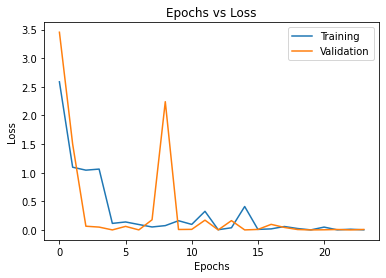

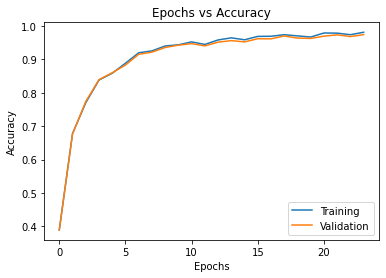

Final training accuracy: 0.981398986635835 
 final validation accuracy: 0.9742909610283615 
 final training loss: 0.0014405258698388934 
 final validation loss: 0.008040221408009529


In [15]:
#running the actual loop on current best parameters
model = GTSRBClassifier(conv1Channels=83, conv2Channels=94, features=147)
batch_size = 800
epochs = 24
learningRate = 0.000922458
#print(type(train_loader))
train(model=model,train_loader=train_loader,valid_loader=val_loader,batch_size=batch_size,num_epochs=epochs,learning_rate=learningRate,plot=True)

In [32]:
test(model=model, test_loader=test_loader)

entered test
current test Loss 0.008387191221117973 
current test Accuracy 0.9794945038129002 
exit test
